# Modeling and categorizing tweets that contain a location about hurricane-related events


In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sqlalchemy import create_engine
import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
import spacy
from numpy import loadtxt
import numpy as np
import os
import json
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_scorenlp = spacy.load('en_default')

In [ ]:
nlp = spacy.load('en_default')
engine = create_engine('postgres://%s:%s@104.154.139.71/%s'%('postgres',os.getenv('db_password'),'tweets_db'))
connection = engine.connect()

First we import everything ( following this xgboost tutorial: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/ ). Then lets get the tweets for training and extract features. 


Features that need to be added:

 * Extract OSM node names and then compare uniqueness of OSM nodes at the text level (NoOfDistinctOSMNodes)
 * Match node with entity, find the population and if population field exists for the nodes 
 * Capitalization of the entity names
 


In [204]:
tweets = pd.read_sql_query("""
select 
    tweets.tweet_id,
    tweet_text,
    to_char(tweet_date, 'HH24') as tweet_hour,
    isALocationTweet,
    (
        select count(id) 
        from osmtweetlocalization 
        where osmtweetlocalization.tweet_id= tweets.tweet_id
    ) as NoOfOSMNodes,
    (
        select count(distinct osm_id)
        from osmtweetlocalization
        where osmtweetlocalization.tweet_id = tweets.tweet_id
        
    ) as NoOfDistinctOSMNodes,
    case when lower(users.lang) like 'en%%' then TRUE else FALSE end as langIsEnglish, 
    case when lower(tweet_text) like '%%flood%%' then TRUE else FALSE end as floodkey,
    case when lower(tweet_text) like '%%power%%' then TRUE else FALSE end as powerkey,
    case when lower(tweet_text) like '%%wind%%' then TRUE else FALSE end as windkey,
    case when lower(tweet_text) like '%%water%%' then TRUE else FALSE end as waterkey,
    case when lower(tweet_text) like '%%sewage%%' then TRUE else FALSE end as sewagekey,
    case when lower(tweet_text) like '%%severe%%' then TRUE else FALSE end as severekey,
    case when lower(tweet_text) like '%%tornado%%' then TRUE else FALSE end as tornadokey,
    case when lower(tweet_text) like '%%damage%%' then TRUE else FALSE end as damagekey,
    case when lower(tweet_text) like '%%rain%%' then TRUE else FALSE end as rainkey,
    case when lower(tweet_text) like '%%estate%%' then TRUE else FALSE end as estatekey,
    case when lower(tweet_text) like '%%luxur%%' then TRUE else FALSE end as luxurykey,
    case when lower(tweet_text) like '%%condo%%' then TRUE else FALSE end as condokey,
    case when lower(tweet_text) like '%%sale%%' then TRUE else FALSE end as salekey


from tweetsTrainLocation01  
join tweets on
    tweets.tweet_id = tweetsTrainLocation01.tweet_id
join users on
    tweets.user_id = users.id
where 
    isALocationTweet is not null
    /*and (
           lower(tweet_text) like '%%irma%%' 
        or lower(tweet_text) like '%%flood%%' 
        or lower(tweet_text) like '%%power%%' 
    )*/
    ;

""",engine)
tweets

,tweet_id,tweet_text,tweet_hour,isalocationtweet,noofosmnodes,noofdistinctosmnodes,langisenglish,floodkey,powerkey,windkey,waterkey,sewagekey,severekey,tornadokey,damagekey,rainkey,estatekey,luxurykey,condokey,salekey
0,907605279130370048,#MyTrain T0123 | Randfontein-Park Station 11 ...,14,True,2,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False
1,907285685043974150,The owner of Native Son Winery in Randleman is...,16,True,1,1,True,False,False,True,False,False,False,False,False,True,False,False,False,False
2,907280244339625984,Irma gave me a new found loyalty to @BurgerKin...,16,False,4,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,906761182526283776,Favorite beach bar Soggy Dollar. I need a Pain...,06,False,1,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,907369779882631168,"Marker 48 Brewing - Weeki Wachee, Florida http...",22,False,1,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5,907729847107035136,"Flash Flood Warning - Connersville, FL - 10:17...",22,True,2,2,True,True,False,False,False,False,False,False,False,False,False,False,False,False
6,907306317374803969,Hurricane Irma sends plane hurtling into car i...,18,True,3,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
7,908016657821560832,South Miami Hospital COMMUNITY DISCOUNT 25% o...,17,False,2,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
8,906856535426465792,@Telemundo51 @Harold_T51 @ADelgadoT51 @ArielT5...,12,False,1,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False
9,908327294405509120,Repost from big_low good morning beautiful peo...,13,True,1,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False


Now we will add some more spacy-entity based features to this list.

In [205]:

for idx,tweet in tweets.iterrows():
    doc= nlp(tweet.tweet_text)
    tweets.loc[idx,'TotalNoOfEntities'] = len(doc.ents)
    nGPEs =0
    nLOCs=0
    nORGs=0
    nOthers=0
    for ent in doc.ents:
        #print(str(idx),ent.ent_id_,ent.label,ent.label_, ent.text)
        if ent.label == 380:
            nORGs+=1
        elif ent.label== 381:
            nGPEs+=1
        elif ent.label== 382:
            nLOCs+=1
        else:
            nOthers+=1
    tweets.loc[idx,'nGPEentities'] = nGPEs
    tweets.loc[idx,'nLOCentities'] = nLOCs
    tweets.loc[idx,'nORGentities'] = nORGs
    tweets.loc[idx,'nOTHERentities'] = nOthers
    tweets.loc[idx,'nGPEandLOCs'] = nGPEs+nLOCs

        #if ent.label in (380,381,382):
        #     a=2
    



Lets make the variables for model-building:

In [206]:
tweets2 = tweets.copy()
#tweets2.drop('tweet_text')
#tweets2.drop('tweet_id')
del tweets2['tweet_text']
del tweets2['tweet_id']

X = tweets2.copy()
del X['isalocationtweet']
X['tweet_hour'] = X['tweet_hour'].astype(int)
Y = tweets2['isalocationtweet']
# split data into train and test sets
seed = 908008
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
#model = XGBClassifier()
model = RandomForestClassifier()



Now we will do a grid search to find the optimal parameters for this model.

In [197]:
# We don't want this grid search to run everytime this jupyter notebook is run!
if False:

    # Utility function to report best scores
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")


    # use a full grid over all parameters
    param_grid = {
                  "n_estimators": [1,5,9,10,11,12,13],
                  "max_depth": [12,11,10,8,7,6,None],
                  "max_features": [1, 3,5, 10],
                  "min_samples_split": [2, 3,4 ],
                  "min_samples_leaf": [1, 3,5, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    grid_search = GridSearchCV(model, param_grid=param_grid)
    start = time()
    grid_search.fit(X_train, y_train)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)


GridSearchCV took 554.66 seconds for 9408 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.759 (std: 0.041)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 9}

Model with rank: 2
Mean validation score: 0.756 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 9}

Model with rank: 3
Mean validation score: 0.749 (std: 0.034)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 11, 'max_features': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1}

Model with rank: 3
Mean validation score: 0.749 (std: 0.011)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 10}




Now we will run the ranodom forest classifier with the optimal parameters.

In [253]:


model = RandomForestClassifier(
    bootstrap = False,
    max_depth = 8,
    criterion='gini',
    max_features=1,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=12)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

Accuracy: 60.32%


array([[71, 61],
       [39, 81]])

Feature ranking:


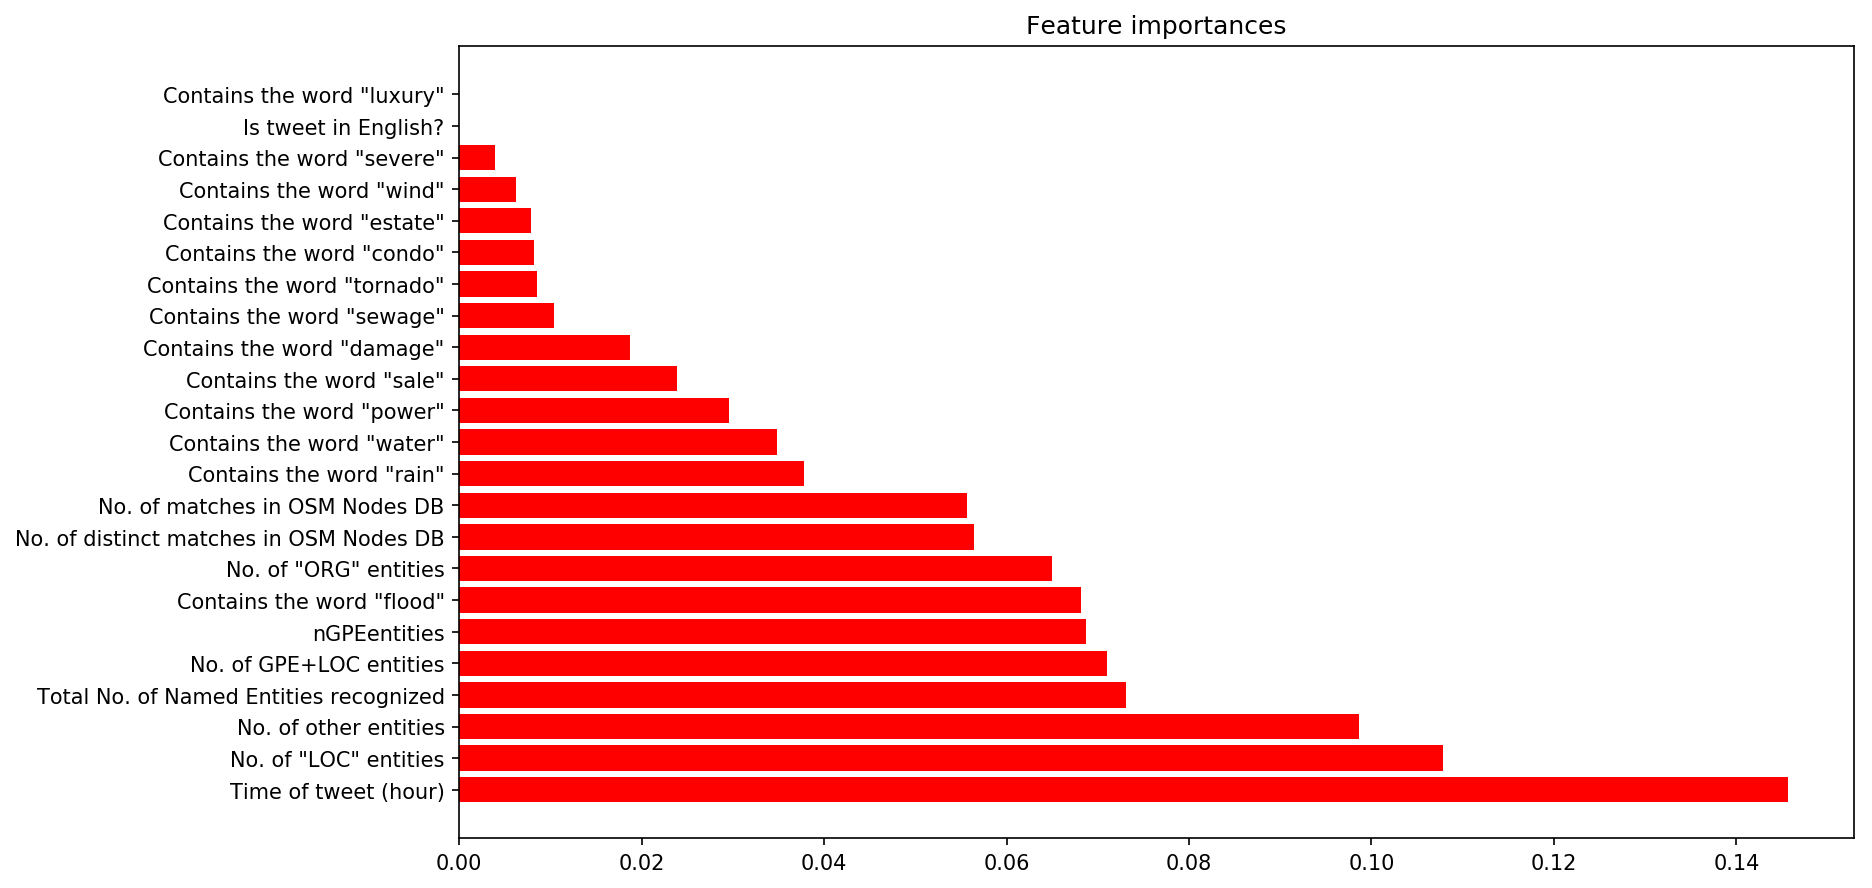

In [272]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(X_train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12, 7),dpi=150)
plt.title("Feature importances")
#plt.bar(range(X_train.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)

#plt.xticks(range(X.shape[1]), X_train.keys())
#plt.xlim([-1, X.shape[1]])
#print(importances[indices])
#print(range(X_train.shape[1]))
keycodes = X_train.keys().copy()
lookupvals = ['tweet_hour','noofosmnodes','noofdistinctosmnodes','langisenglish','floodkey','powerkey','windkey','waterkey','sewagekey','severekey','tornadokey','damagekey','rainkey','estatekey','luxurykey','condokey','salekey','TotalNoOfEntities','nGPEentities   ','nLOCentities','nORGentities','nOTHERentities','nGPEandLOCs']
replacevals = ['Time of tweet (hour)','No. of matches in OSM Nodes DB','No. of distinct matches in OSM Nodes DB','Is tweet in English?','Contains the word "flood"','Contains the word "power"','Contains the word "wind"','Contains the word "water"','Contains the word "sewage"','Contains the word "severe"','Contains the word "tornado"','Contains the word "damage"','Contains the word "rain"','Contains the word "estate"','Contains the word "luxury"','Contains the word "condo"','Contains the word "sale"','Total No. of Named Entities recognized','No. of "GPE" entities','No. of "LOC" entities','No. of "ORG" entities','No. of other entities','No. of GPE+LOC entities']
for idx,lookup in enumerate(lookupvals):
    keycodes = keycodes.str.replace(lookup,replacevals[idx])
#print(keycodes)
plt.barh(range(X_train.shape[1]),importances[indices],
       color="r", align="center")
plt.yticks(range(X.shape[1]), keycodes[indices])
plt.show()


Confusion matrix, without normalization
[[71 61]
 [39 81]]


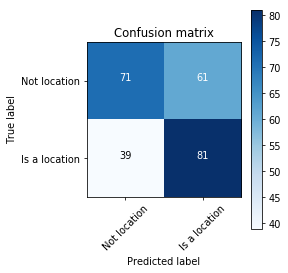

Normalized confusion matrix
[[ 0.53787879  0.46212121]
 [ 0.325       0.675     ]]


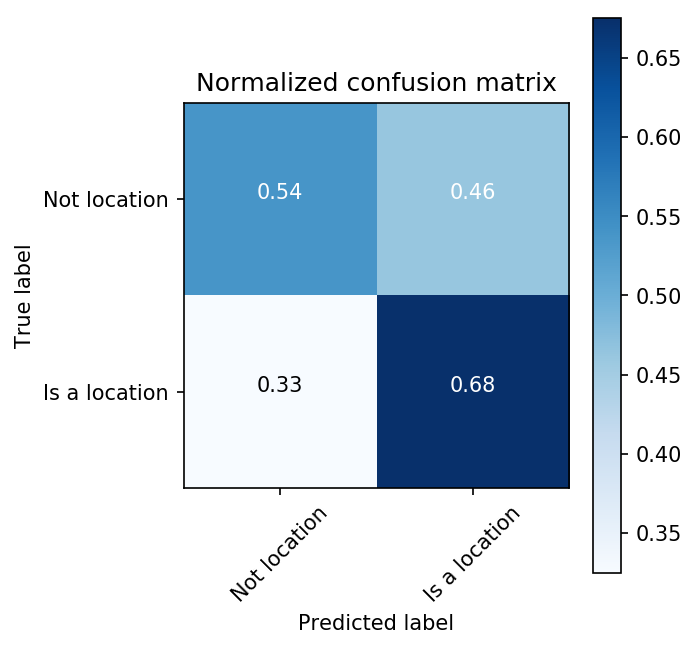

In [273]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(4,4),dpi=70)

plot_confusion_matrix(cnf_matrix, classes=['Not location','Is a location'], normalize=False,
                      title='Confusion matrix')

plt.show()
# Plot normalized confusion matrix
plt.figure(figsize=(4.5,4.5),dpi=150)

plot_confusion_matrix(cnf_matrix, classes=['Not location','Is a location'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Lets try to categorize the real data now.

In [151]:
tweetstopredict = pd.read_sql_query("""
select 
    tweets.tweet_id,
    tweet_text,
    to_char(tweet_date, 'HH24') as tweet_hour,
    (
        select count(id) 
        from osmtweetlocalization 
        where osmtweetlocalization.tweet_id= tweets.tweet_id
    ) as NoOfOSMNodes,
    (
        select count(distinct osm_id)
        from osmtweetlocalization
        where osmtweetlocalization.tweet_id = tweets.tweet_id
        
    ) as NoOfDistinctOSMNodes,
    case when lower(users.lang) like 'en%%' then TRUE else FALSE end as langIsEnglish, 
    case when lower(tweet_text) like '%%flood%%' then TRUE else FALSE end as floodkey,
    case when lower(tweet_text) like '%%power%%' then TRUE else FALSE end as powerkey,
    case when lower(tweet_text) like '%%wind%%' then TRUE else FALSE end as windkey,
    case when lower(tweet_text) like '%%water%%' then TRUE else FALSE end as waterkey,
    case when lower(tweet_text) like '%%sewage%%' then TRUE else FALSE end as sewagekey,
    case when lower(tweet_text) like '%%severe%%' then TRUE else FALSE end as severekey,
    case when lower(tweet_text) like '%%tornado%%' then TRUE else FALSE end as tornadokey,
    case when lower(tweet_text) like '%%damage%%' then TRUE else FALSE end as damagekey,
    case when lower(tweet_text) like '%%rain%%' then TRUE else FALSE end as rainkey,
    case when lower(tweet_text) like '%%estate%%' then TRUE else FALSE end as estatekey,
    case when lower(tweet_text) like '%%luxur%%' then TRUE else FALSE end as luxurykey,
    case when lower(tweet_text) like '%%condo%%' then TRUE else FALSE end as condokey,
    case when lower(tweet_text) like '%%sale%%' then TRUE else FALSE end as salekey


from tweetsTrainLocation01  
join tweets on
    tweets.tweet_id = tweetsTrainLocation01.tweet_id
join users on
    tweets.user_id = users.id
where isALocationTweet is null;
""",engine)
print('Finished SQL reading.')
for idx,tweet in tweetstopredict.iterrows():
    doc= nlp(tweet.tweet_text)
    tweetstopredict.loc[idx,'TotalNoOfEntities'] = len(ent)
    nGPEs =0
    nLOCs=0
    nORGs=0
    nOthers=0
    for ent in doc.ents:
        #print(str(idx),ent.ent_id_,ent.label,ent.label_, ent.text)
        if ent.label == 380:
            nORGs+=1
        elif ent.label== 381:
            nGPEs+=1
        elif ent.label== 382:
            nLOCs+=1
        else:
            nOthers+=1
    tweetstopredict.loc[idx,'nGPEentities'] = nGPEs
    tweetstopredict.loc[idx,'nLOCentities'] = nLOCs
    tweetstopredict.loc[idx,'nORGentities'] = nORGs
    tweetstopredict.loc[idx,'nOTHERentities'] = nOthers
    tweetstopredict.loc[idx,'nGPEandLOCs'] = nGPEs+nLOCs
print('Finished NER work.')


Finished SQL reading.
Finished NER work.


In [152]:
tweetstopredict2 = tweetstopredict.copy()
del tweetstopredict2['tweet_text']
del tweetstopredict2['tweet_id']
tweetstopredict2['tweet_hour'] = tweetstopredict2['tweet_hour'].astype(int)

y_pred = model.predict(tweetstopredict2)
print('Finished predictions')


Finished predictions


In [153]:
print(len(y_pred))
for idx,tweet in tweetstopredict.iterrows():
    if idx<900:
        continue
    print(idx,y_pred[idx],tweet.tweet_text)
    if idx>1000:
        break

6040
900 False Foreclosures Deals In Santa Rosa Beach Florida: https://t.co/HWeQds9YwU via @YouTube
901 False Foreclosures Deals In Mexico Beach Florida: https://t.co/3jUZ2SK3Tu via @YouTube
902 False @fbcoem Are there any roads in Fort Bend County that are still closed due to Hurricane Harvey?
903 False Breaking News for #32174: This is how Hurricane Irma impacted Ormond Beach: https://t.co/Vid7GUWgpq #Ormondbeach
904 False Enjoy a meal at Shady Maple Smorgasbord and at the same time help those devastated by Hurricane Harvey. $1 per meal… https://t.co/SqXVBt1oCz
905 False Here's your periodic reminder for the US East Coast (including the DMV) to keep an eye on Hurricane Jose next week: https://t.co/oxaIQluQT5
906 False BGM issues Areal Flood Advisory for Seneca, Steuben, Yates [NY] till Sep 14, 10:45 AM EDT https://t.co/O4IrkEab7K
907 False BGM issues Areal Flood Advisory for Seneca, Steuben, Yates [NY] till Sep 14, 10:45 AM EDT https://t.co/Z0bLIDtGAB
908 True Flood Advisory in effec

Now lets update the table with the predictions.

In [154]:
print("Clearing the prediction column first.")
connection.execute("UPDATE tweetsTrainLocation01 set predictedIsALocationTweet = null;")
for tf in [True,False]:
    sqlUpdateStart = "UPDATE tweetsTrainLocation01 set predictedIsALocationTweet="+str(tf)+" WHERE tweet_id in ("
    #print(sqlUpdateStart)
    updatelist = ""
    for idx,tweet in tweetstopredict.iterrows():
        if y_pred[idx] == tf:
            updatelist = updatelist+str(tweet.tweet_id)+","
        if idx>0 and ((idx%1000)==0 or idx==len(tweetstopredict)-1):
            sqlstring = sqlUpdateStart+updatelist[:-1]+")"
            connection.execute(sqlstring)
            print("Updated 1000 entries.")
            updatelist=""
print('done')            
            


Clearing the prediction column first.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
Updated 1000 entries.
done


Now lets make the GeoJSON file. This is what index.html statically loads using Mapbox's library to visualize tweet locations.

In [155]:
tweetlocations = pd.read_sql_query("""

  
    select left(tweet_text,140),lat,lon,
   date_part('day',tweet_date) as day,
   date_part('hour',tweet_date) as hour,
   date_part('minute',tweet_date) as minute,   
   case when lower(tweet_text) like '%%flood%%' then 'TRUE' else 'FALSE' end as floodkey,   
   case when lower(tweet_text) like '%%power%%' then 'TRUE' else 'FALSE' end as powerkey,
   case when lower(tweet_text) like '%%rain%%' then 'TRUE' else 'FALSE' end as rainkey,
   tweets.tweet_id::text

from tweets 
join osmtweetlocalization 
    on osmtweetlocalization.tweet_id = tweets.tweet_id 
join planet_osm_nodes
    on osmtweetlocalization.osm_id = planet_osm_nodes.id
join tweetsTrainLocation01
    on tweets.tweet_id = tweetsTrainLocation01.tweet_id
where 
    tweets.tweet_id in (
        select tweet_id 
        from osmtweetlocalization  
        group by tweet_id 
    )
    and (
        predictedIsALocationTweet is True 
        OR
        isALocationTweet is True
    )
    
order by random();



""",engine)
print("Executed the sql.")
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    """
    Thanks to Goeff Boeing
    http://geoffboeing.com/2015/10/exporting-python-data-geojson/
    """
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

tweetlocs2 = tweetlocations.copy()
tweetlocs2.lat = tweetlocs2.lat/10000000
tweetlocs2.lon = tweetlocs2.lon/10000000
tweetlocs2.day = (tweetlocs2.day-8)*24+tweetlocs2.hour
dataout = df_to_geojson(tweetlocs2,['left','hour','day','minute','floodkey','powerkey','rainkey','tweet_id'],lat='lat',lon='lon')
dataout2=dataout
print('Writing geojson file...')
with open('trainedTweetLocations.geojson', 'w') as outfile:
    json.dump(dataout2, outfile,indent=2)
print('done')


Executed the sql.
Writing geojson file...
done


In [156]:
len(tweetlocations)


5533